In [127]:
import giraffe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netZooPy.panda.panda import Panda
from netZooPy.otter.otter import otter
import seaborn as sn
from sklearn.decomposition import PCA

In [2]:
motif = pd.read_csv("data/lung/raw/motif.csv", index_col = 0)
motif = motif[~motif.index.duplicated(keep='first')]
print(motif.shape)

expression = pd.read_csv("data/lung/raw/expression.csv", index_col = 0)
expression = expression[~expression.index.duplicated(keep='first')]
print(expression.shape)

ischemic_time = pd.read_csv("data/lung/raw/ischemic.csv", index_col = 0)
print(ischemic_time.shape)

PPI = pd.read_csv("data/lung/raw/PPI.csv", index_col = 0)
print(PPI.shape)

(16470, 447)
(16470, 604)
(604, 1)
(447, 447)


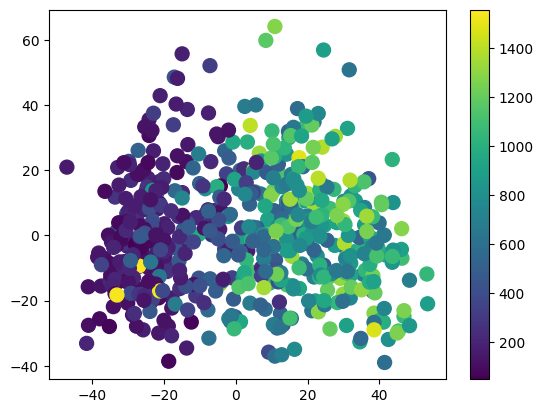

In [131]:
pca = PCA(n_components=2)
components = pca.fit_transform(expression.T)

f, ax = plt.subplots()
points = ax.scatter(components[:, 0], components[:, 1], c=ischemic_time.to_numpy(), s=100)
f.colorbar(points)

In [3]:
translate = pd.read_csv("data/lung/raw/gen_v26_mapping.csv", index_col = 0)
adj = pd.read_csv("data/lung/raw/adjusted.csv")
adjusted = pd.DataFrame(0, index = expression.index, columns = expression.columns)
cols = []
for i in range(len(adj.columns)):
    if adj.columns[i] in set(translate['gene_id']):
        cols.append(translate[translate['gene_id'] == adj.columns[i]]['gene_name'].values[0])
for g in adjusted.index:
    adjusted.loc[g] = adj[adj.columns[cols.index(g)]].values

In [4]:
def chip_validation(R):
    chip = pd.read_csv("data/lung/raw/chip_seq.csv", index_col = 0)
    chip.sort_index(inplace=True)
    chip.sort_index(axis=1,inplace=True)

    R.sort_index(inplace=True)
    R.sort_index(axis=1,inplace=True)

    commonTFs  = chip.index[chip.index.isin(R.index)]
    commonGenes= chip.columns[chip.columns.isin(R.columns)]
    
    gt = chip.loc[commonTFs, commonGenes]
    pred = R.loc[commonTFs, commonGenes]
    return gt, pred

In [60]:
ground_truths = []
preds = []
model_names = ["PANDA", "GIRAFFE", "GIRAFFE adjusted", "GIRAFFE limma", "OTTER", "OTTER limma", "Motif"]

In [61]:
panda_regulation = pd.read_csv("data/lung/panda_res.txt", sep = " ", index_col = 'tf')
commonTFs  = panda_regulation.columns[panda_regulation.columns.isin(PPI.columns)]
commonGenes= panda_regulation.index[panda_regulation.index.isin(expression.index)]
gt_panda, reg_panda = chip_validation(panda_regulation[commonTFs].loc[commonGenes].T)
ground_truths.append(gt_panda)
preds.append(reg_panda)

In [62]:
giraffe_regulation = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), iterations = 10, lr = 1e-5, save_computation = True).get_regulation()
gt_giraffe, reg_giraffe = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_giraffe)
preds.append(reg_giraffe)

In [63]:
giraffe_regulation = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), adjusting = ischemic_time, iterations = 10, lr = 1e-5, save_computation = True).get_regulation()
gt_adj, reg_adj = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_adj)
preds.append(reg_adj)

In [64]:
giraffe_regulation = giraffe.Giraffe(adjusted.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), iterations = 10, lr = 1e-5, save_computation = True).get_regulation()
gt_giraffe, reg_giraffe = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_giraffe)
preds.append(reg_giraffe)

In [65]:
otter_regulation = otter(motif.T.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), np.corrcoef(expression.to_numpy()))
gt_otter, reg_otter = chip_validation(pd.DataFrame(np.abs(otter_regulation), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_otter)
preds.append(reg_otter)

In [66]:
otter_regulation = otter(motif.T.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), np.corrcoef(adjusted.to_numpy()))
gt_otter, reg_otter = chip_validation(pd.DataFrame(np.abs(otter_regulation), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_otter)
preds.append(reg_otter)

In [67]:
gt_motif, reg_motif = chip_validation(motif.T)
ground_truths.append(gt_motif)
preds.append(reg_motif)

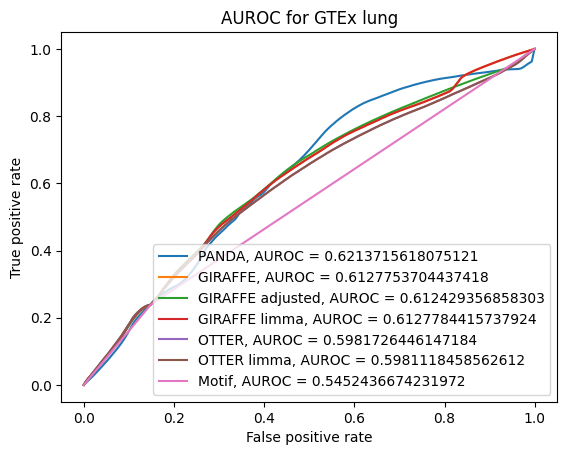

In [68]:
for i in range(len(ground_truths)):
    gt = ground_truths[i].to_numpy()  
    pred = preds[i].to_numpy()
    auc, tpr, fpr = giraffe.utils.evaluate_regulation_auroc(gt, pred)
    plt.plot(fpr, tpr, label=model_names[i] + ", AUROC = " + str(auc))
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("AUROC for GTEx lung")
plt.show()  

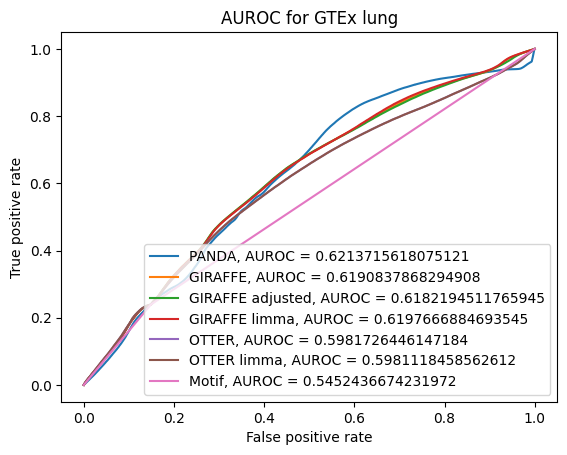

In [13]:
for i in range(len(ground_truths)):
    gt = ground_truths[i].to_numpy()  
    pred = preds[i].to_numpy()
    auc, tpr, fpr = giraffe.utils.evaluate_regulation_auroc(gt, pred)
    plt.plot(fpr, tpr, label=model_names[i] + ", AUROC = " + str(auc))
plt.legend(loc='lower right')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("AUROC for GTEx lung")
plt.show()  

# Intervention

In [17]:
giraffe_regulation = giraffe.Giraffe(expression.to_numpy(), motif.to_numpy(), PPI.to_numpy() + np.eye(PPI.shape[0]), iterations = 200).get_regulation()
gt_giraffe, reg_giraffe = chip_validation(pd.DataFrame(np.abs(giraffe_regulation.T), index = PPI.columns, columns = expression.index))
ground_truths.append(gt_giraffe)
preds.append(reg_giraffe)

In [9]:
interventions = ['TP53', 'STAT6', 'NFE2L2', 'YBX1', 'NKX2-1', 'GABPA', 'ETS2', 'NFYA', 'RELB', 'TFAP2C']

In [60]:
def intervention_score(R, intervention_name):
    tf_index = list(R.columns).index(intervention_name)
    bpath = "data/lung/raw/"
    intervention = pd.read_csv(bpath + intervention_name + '.csv')[['Target Gene', 'Mean Expr. of Control', 'Mean Expr. of Treat']]
    intervention['diff'] = intervention[intervention.columns[1]] > intervention[intervention.columns[2]]
    diffs = [np.abs(intervention[intervention.columns[1]].to_numpy() - intervention[intervention.columns[2]].to_numpy())]
    diffs.sort()
    thr = diffs[0][int(len(diffs) * 0.7)]
    score = 0
    tot = 0
    mm = 0
    mp = 0
    pm = 0
    pp = 0
    for i in range(intervention.shape[0]):
        gene = intervention.iloc[i]['Target Gene']
        if gene not in expression.index:
            continue
        if np.abs(intervention.loc[i][intervention.columns[1]] - intervention.loc[i][intervention.columns[2]]) < thr:
            continue
        tot += 1
        if R.to_numpy()[list(R.index).index(gene), tf_index] > 0:
            if intervention.iloc[i]['diff']:
                pp += 1
                score += 1
            else:
                pm += 1
        else:
            if not intervention.iloc[i]['diff']:
                mm += 1
                score += 1
            else:
                mp += 1
    sn.heatmap(data = [[pp, pm], [mp, mm]], annot = True)
    plt.show()
    print(intervention_name + " accuracy: " + str(score / tot))

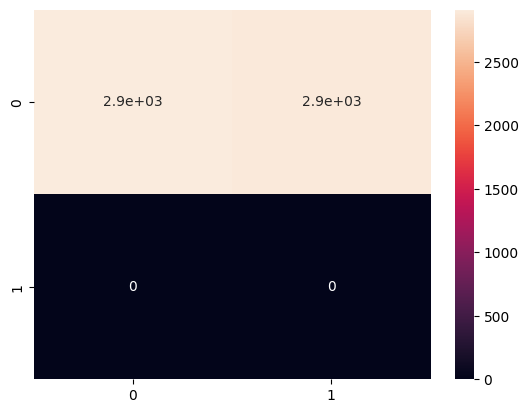

TP53 accuracy: 0.5011189533482527


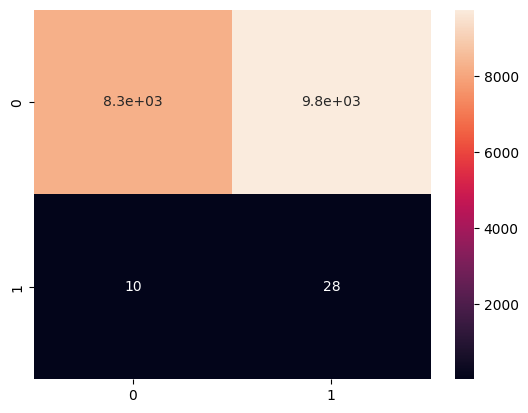

STAT6 accuracy: 0.45929041899595946


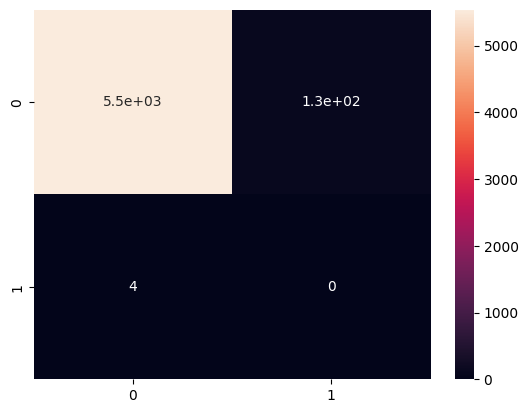

NFE2L2 accuracy: 0.9768877911079746


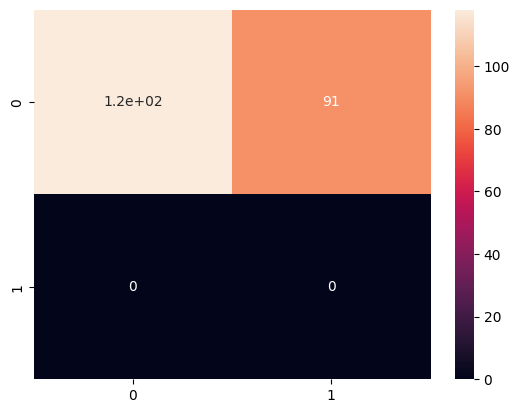

YBX1 accuracy: 0.5645933014354066


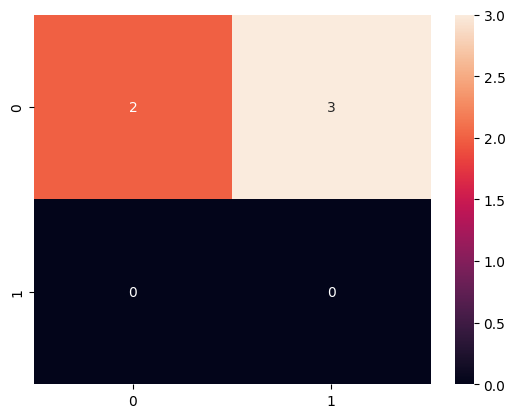

NKX2-1 accuracy: 0.4


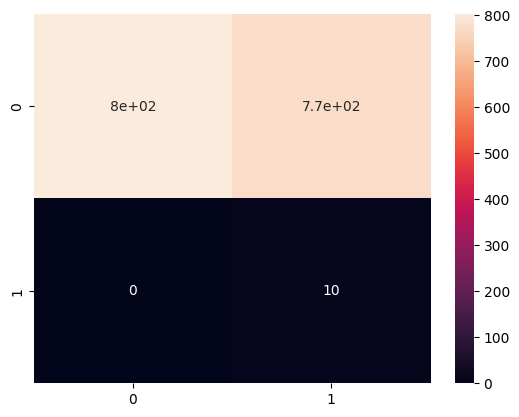

GABPA accuracy: 0.5122873345935728


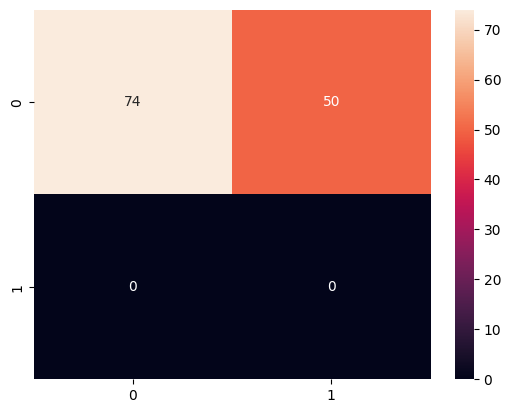

ETS2 accuracy: 0.5967741935483871


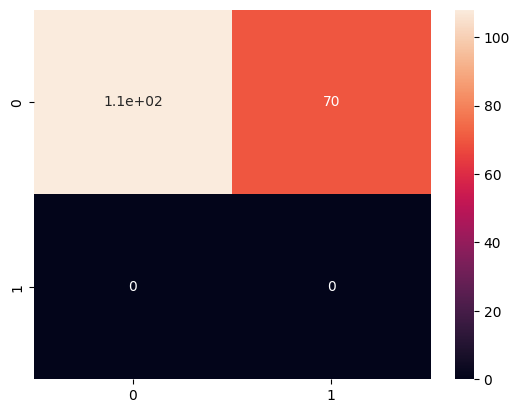

NFYA accuracy: 0.6067415730337079


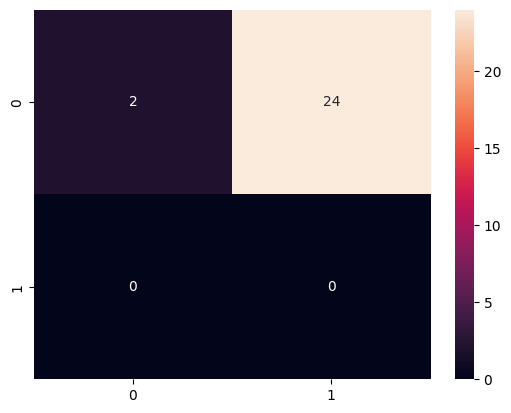

RELB accuracy: 0.07692307692307693


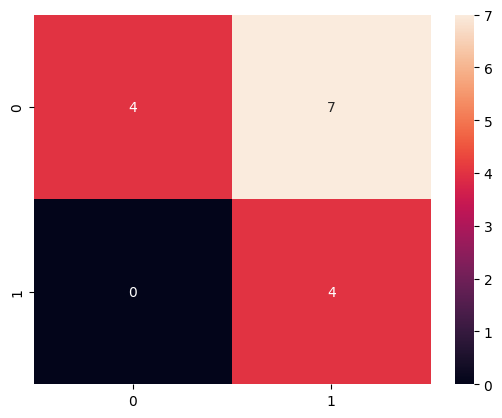

TFAP2C accuracy: 0.5333333333333333


In [61]:
# GIRAFFE
for intervention in interventions:
    intervention_score(pd.DataFrame(giraffe_regulation, index = expression.index, columns = motif.columns), intervention)